In [45]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from PIL import Image

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam


print('GPU: ', tf.test.is_gpu_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU:  True


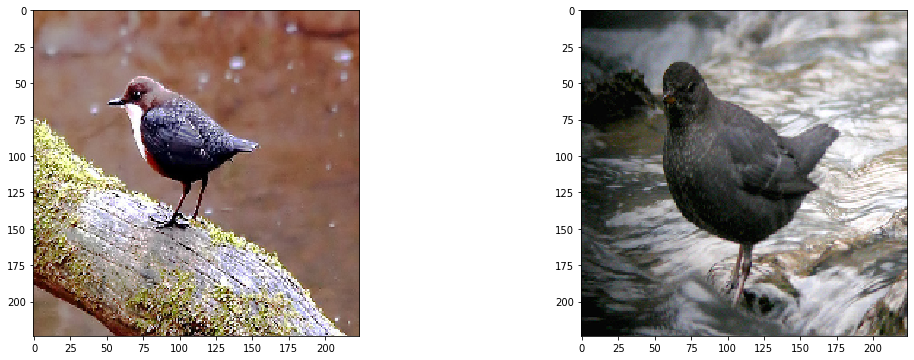

In [46]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = tf.keras.preprocessing.image.load_img('images/ouzel1.jpg', target_size=(224, 224))
img2 = tf.keras.preprocessing.image.load_img('images/ouzel2.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [47]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [48]:
saliency = Saliency(model, model_modifier=None)
X = np.array([np.array(img1), np.array(img2)]) / 127. - 1.
X = tf.constant(X)
def losses(output):
    return output[:, 20]

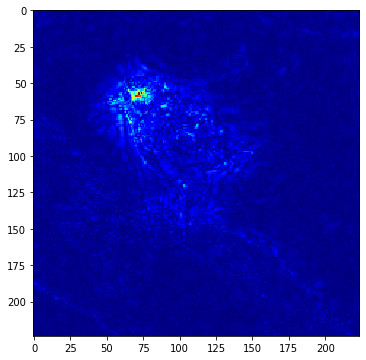

In [49]:
grads = saliency(losses, X, smooth_samples=50)

grads = np.max(grads, axis=-1)
arr_min = np.min(grads)
arr_max = np.max(grads)
norm = (grads - arr_min) / (arr_max - arr_min + tf.keras.backend.epsilon())
val = (1. - 0.) * norm + 0.

plt.imshow(val[0], cmap='jet')

In [50]:
gradcam = Gradcam(model, model_modifier=None)

X = np.array([np.array(img1), np.array(img2)]) / 127. - 1.
X = tf.constant(X)
def losses(output):
    return output[:, 20]
cam = gradcam(losses, X)

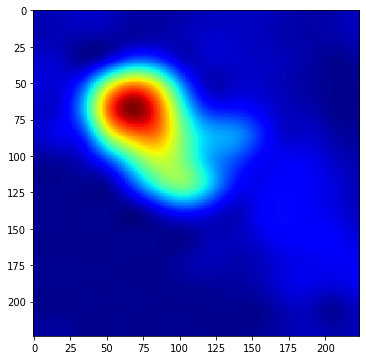

In [51]:
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (18, 6)


arr_min = np.min(cam)
arr_max = np.max(cam)
norm = (cam - arr_min) / (arr_max - arr_min + tf.keras.backend.epsilon())
val = (1. - 0.) * norm + 0.
v = val[0]
jet_heatmap = np.uint8(cm.jet(v)[..., :3] * 255)
plt.imshow(jet_heatmap)

In [52]:
from tf_keras_vis.activation_maximization import ActivationMaximization
def modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
am = ActivationMaximization(model, model_modifier=modifier)
am

In [ ]:
from tf_keras_vis.utils.callbacks import GifGenerator, Print
from tensorflow.keras import backend as K
from tf_keras_vis.utils.regularizers import TotalVariation, L2Norm
from tf_keras_vis.utils.input_modifiers import Jitter

activation = am(lambda x: x[:, 20],
                steps=512,
                input_modifiers=Jitter(8),
                regularizers=[TotalVariation(10.), L2Norm(10.)],
                optimizer=tf.optimizers.RMSprop(0.8),
                callbacks=[Print(interval=50)],
               )
plt.imshow(activation[0].astype(np.uint8))

[000] Losses: [0.16168112], Regularization: [array([285.77618], dtype=float32)]
[050] Losses: [256.5789], Regularization: [array([456.308], dtype=float32)]
[100] Losses: [546.8698], Regularization: [array([669.5597], dtype=float32)]
[150] Losses: [878.2151], Regularization: [array([903.28595], dtype=float32)]
